<a href="https://colab.research.google.com/github/IamJk28/aircraftgit/blob/main/Copy_of_Aircraft_Model_Training_Detection_resnet_tryout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Setup Paths

In [ ]:
import os

In [ ]:
# this cell allows the google colab session to access your drive contents where we have uploaded images and Annotations
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#currently running off of a mobnet, change in the future
#trying: Faster R-CNN ResNet50 V1 640x640

CUSTOM_MODEL_NAME = 'my_faster_r_cnn_resnet50'
PRETRAINED_MODEL_NAME = 'faster_rcnn_resnet50_v1_640x640_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_resnet50_v1_640x640_coco17_tpu-8.tar.gz'

TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

In [ ]:
folderpaths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow','scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow','models'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME),
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'export'),
    'TFJS_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfjsexport'),
    'TFLITE_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'),
    'PROTOC_PATH':os.path.join('Tensorflow','protoc'),
    'TRAIN_PATH':os.path.join('Tensorflow','workspace','images','train'),
    'TEST_PATH':os.path.join('Tensorflow','workspace','images','test'),
    'COLLECT_PATH':os.path.join('Tensorflow','workspace','images','collectedimages')
 }

In [ ]:
files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(folderpaths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME),
    'LABELMAP': os.path.join(folderpaths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

In [ ]:
for path in folderpaths.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
        if os.name == 'nt':
            !mkdir {path}

In [ ]:
source_folder0 = "drive/MyDrive/aircraftimage/archive.tar.gz"
destination_folder0 = "Tensorflow/workspace/images"

if os.path.exists(source_folder0):
   shutil.copy(source_folder0, destination_folder0)

In [ ]:

#this requires an imported archive.tar, which could be better than importing the uncompressed images/xml files straight from google drive - haven't done this yet anyway
# OPTIONAL IF RUNNING ON COLAB - this creates an archive of the images and labels and which (test/train) folders they were in - improve this later
ARCHIVE_FILES = os.path.join(folderpaths['IMAGE_PATH'], 'archive.tar.gz')
if os.path.exists(ARCHIVE_FILES):
  !tar -zxvf {ARCHIVE_FILES}

In [ ]:
import shutil
#use the first two source_folder strings in future. upload the images and Annotations files from Microsoft teams INTO a new file (here we have called it "aircraftimage" ,change the path of source folders if you call it something else)

#this code takes the "images" and "Annotations" files that you have uploaded into Google Drive and copies them in to the directory Tensorflow/workspace/collectedimages .from here using some later process/code we split the collected images(and xml files) into training and testing sets

source_folder1 = "drive/MyDrive/aircraftimage/images"
source_folder2 = "drive/MyDrive/aircraftimage/Annotations"
destination_folder = "Tensorflow/workspace/images/collectedimages"

source_folders = [source_folder1, source_folder2]

for source_folder in source_folders:
    source_files = os.listdir(source_folder)
    for file_name in source_files:
        source_file = os.path.join(source_folder, file_name)
        destination_file = os.path.join(destination_folder, file_name)
        shutil.copy(source_file, destination_file)


Optional resizing step -- We can resize images and labels to match the correct input size for the model (if the chosen model does not have an inbuilt image_resizer, and if this hasn't already been done locally

In [ ]:
import cv2
import os

def resize_images(input_folder, output_folder, new_width, new_height):
    """Iterates through all images in a given input folder (input_folder) and resizes them to a specified size.
    run annotation_converter.py afterwards to convert any existing/outstanding xml files to the proper size.
    """
    if not os.path.exists(output_folder):
      os.makedirs(output_folder)


    for filename in os.listdir(input_folder):
      if filename.endswith('JPG'):
        input_path = os.path.join(input_folder, filename)
        image = cv2.imread(input_path)
        if image is not None:
          # Resize the image
          resized_image = cv2.resize(image, (new_width, new_height))

          # Save the resized image to the output folder
          output_path = os.path.join(output_folder, filename)
          cv2.imwrite(output_path, resized_image)







In [ ]:
#uncheck this if you want to resize images in the cloud
#resize_images({Tensorflow/workspace/images/collectedimages}, {Tensorflow/workspace/images/resizedcollectedimages}, #new_width, new_height)

SyntaxError: ignored

In [ ]:
import cv2
import os
import xml.etree.ElementTree as ET

def resize_xml_annotations(xml_folder, output_folder, new_size):
    """ Iterates through all xml_files in a given input folder (xml_folder variable)
    and resizes them to map to the same location on a resized image.
    """
    new_width, new_height = new_size

    for xml_file in os.listdir(xml_folder):
        if xml_file.endswith('.xml'):
            xml_path = os.path.join(xml_folder, xml_file)
            tree = ET.parse(xml_path)
            root = tree.getroot()

            image_size = root.find('size')
            image_width = int(image_size.find('width').text)
            image_height = int(image_size.find('height').text)

            width_ratio = new_width / image_width
            height_ratio = new_height / image_height

            for object in root.findall('object'):
                bndbox = object.find('bndbox')

                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)

                xmin = int(xmin * width_ratio)
                ymin = int(ymin * height_ratio)
                xmax = int(xmax * width_ratio)
                ymax = int(ymax * height_ratio)

                bndbox.find('xmin').text = str(xmin)
                bndbox.find('ymin').text = str(ymin)
                bndbox.find('xmax').text = str(xmax)
                bndbox.find('ymax').text = str(ymax)

            # Update the image size in the XML file
            image_size.find('width').text = str(new_width)
            image_size.find('height').text = str(new_height)

            # Save the updated XML file to the output folder
            output_path = os.path.join(output_folder, xml_file)
            tree.write(output_path)

In [ ]:
#uncheck if you want to resize xml labels in the cloud
#resize_xml_annotations(Tensorflow/workspace/images/collectedimages, Tensorflow/workspace/images/resizedcollectedimages, #(new_width,new_height))

Train/Test Split


In [ ]:
!pip install scikit-learn

import os
import random
from sklearn.model_selection import train_test_split
from shutil import copyfile

In [ ]:

# Set the paths to your image and XML directories
image_directory ='Tensorflow/workspace/images/collectedimages'
xml_directory ='Tensorflow/workspace/images/collectedimages'

# Create the train and test directories if they don't exist
train_directory = 'Tensorflow/workspace/images/train'
test_directory = 'Tensorflow/workspace/images/test'
os.makedirs(train_directory, exist_ok=True)
os.makedirs(test_directory, exist_ok=True)

# List all image files in the image directory
image_files = [file for file in os.listdir(image_directory) if file.endswith('.JPG')]

# Set the random seed for reproducibility
random_seed = 42

print(image_files)

# Perform the train/test split
train_files, test_files = train_test_split(image_files, test_size=0.2, random_state=random_seed)


# Move the selected images and their corresponding XML files to the train folder
for file in train_files:
    image_src = os.path.join(image_directory, file)
    #print(image_src)
    xml_src = os.path.join(xml_directory, file.replace('.JPG', '.xml'))
    #print(xml_src)
    image_dest = os.path.join(train_directory, file)
    #print(image_dest)
    xml_dest = os.path.join(train_directory, file.replace('.JPG', '.xml'))
    #print(xml_dest)
    copyfile(image_src, image_dest)
    copyfile(xml_src, xml_dest)

# Move the remaining images and their corresponding XML files to the test folder
for file in test_files:
    image_src = os.path.join(image_directory, file)
    xml_src = os.path.join(xml_directory, file.replace('.JPG', '.xml'))
    image_dest = os.path.join(test_directory, file)
    xml_dest = os.path.join(test_directory, file.replace('.JPG', '.xml'))
    copyfile(image_src, image_dest)
    copyfile(xml_src, xml_dest)


#examine train/test split by unchecking below
#print(train_files)
#print(test_files)


['50bc868d-4c1e279c-AllSkyImage007072319.JPG', '1603aaff-035be52a-AllSkyImage007072404.JPG', '4553afdf-83bedf9d-AllSkyImage007072404.JPG', 'd54543b0-e2869e93-AllSkyImage007127606.JPG', '193fdd88-98c14433-AllSkyImage007072449.JPG', '85ca3d89-d72a6d84-AllSkyImage007072445.JPG', 'f07cfeae-abe7476d-AllSkyImage007072450.JPG', 'f7b0a315-00353503-AllSkyImage007072445.JPG', '50667899-9b068e9a-AllSkyImage007071147.JPG', 'e0cb2bb1-d22ee7c5-AllSkyImage007071094.JPG', '0802119c-b24aa7e5-AllSkyImage007071093.JPG', '5d56e898-654cfbb7-AllSkyImage007072449.JPG', '7ca7060d-2f073843-AllSkyImage007072461.JPG', '6648549c-2246b164-AllSkyImage007071002.JPG', '56fa5579-74af7370-AllSkyImage007072446.JPG']


# 1. Download TF Models Pretrained Models from Tensorflow Model Zoo and Install TFOD

In [ ]:
# https://www.tensorflow.org/install/source_windows

In [ ]:
print(os.name)

posix


In [ ]:
#this downloads the object detection API
if not os.path.exists(os.path.join(folderpaths['APIMODEL_PATH'], 'research', 'object_detection')):
    !git clone https://github.com/tensorflow/models {folderpaths['APIMODEL_PATH']}

Cloning into 'Tensorflow/models'...
remote: Enumerating objects: 89633, done.
remote: Counting objects: 100% (3345/3345), done.
remote: Compressing objects: 100% (1781/1781), done.
remote: Total 89633 (delta 1742), reused 3076 (delta 1534), pack-reused 86288
Receiving objects: 100% (89633/89633), 605.12 MiB | 17.36 MiB/s, done.
Resolving deltas: 100% (63640/63640), done.


In [ ]:
# Converts .protoc files into readable .py format
if os.name=='posix':
    !apt-get install protobuf-compiler
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install .


#leftover code from running on my local machine -ignore
if os.name=='nt':
    url="https://github.com/protocolbuffers/protobuf/releases/download/v3.15.6/protoc-3.15.6-win64.zip"
    wget.download(url)
    !move protoc-3.15.6-win64.zip {folderpaths['PROTOC_PATH']}
    !cd {folderpaths['PROTOC_PATH']} && tar -xf protoc-3.15.6-win64.zip
    os.environ['PATH'] += os.pathsep + os.path.abspath(os.path.join(folderpaths['PROTOC_PATH'], 'bin'))
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && copy object_detection\\packages\\tf2\\setup.py setup.py && python setup.py build && python setup.py install
    !cd Tensorflow/models/research/slim && pip install -e .

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
protobuf-compiler is already the newest version (3.12.4-1ubuntu7.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.
Processing /content/Tensorflow/models/research
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 43.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 64.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.6/116.6 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 51.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
#This seems to be the necessary version of tensorflow ( doesn't seem to work with tensorflow==2.14.0)
!pip install tensorflow==2.13.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 34.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 29.1 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.14.0
    Uninstalling tensorflow-estimator-2.14.0:
      Successfully uninstalled tensorflow-estimator-2.14.0
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.4
    Uninstalling gast-0.5.4:
      Successfully uninstalled gast-0.5.4
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.14.1
    Uninstalling tensorboard-2.14.1:
      Successfully uninstalled tensorboard-2.1

In [ ]:
VERIFICATION_SCRIPT = os.path.join(folderpaths['APIMODEL_PATH'], 'research', 'object_detection', 'builders', 'model_builder_tf2_test.py')
# verify if the installation has worked
!python {VERIFICATION_SCRIPT}

2023-11-06 14:02:38.259513: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-06 14:02:39.434832: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-11-06 14:02:43.277057: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-06 14:02:43.920935: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returnin

In [ ]:
import object_detection

In [ ]:
if os.name =='posix':
    !wget {PRETRAINED_MODEL_URL}
    !mv {PRETRAINED_MODEL_NAME+'.tar.gz'} {folderpaths['PRETRAINED_MODEL_PATH']}
    !cd {folderpaths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}
if os.name == 'nt':
    wget.download(PRETRAINED_MODEL_URL)
    !move {PRETRAINED_MODEL_NAME+'.tar.gz'} {folderpaths['PRETRAINED_MODEL_PATH']}
    !cd {folderpaths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}

--2023-11-06 14:03:43--  http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_resnet50_v1_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 108.177.119.207, 108.177.126.207, 108.177.127.207, ...
Connecting to download.tensorflow.org (download.tensorflow.org)|108.177.119.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 211996178 (202M) [application/x-tar]
Saving to: ‘faster_rcnn_resnet50_v1_640x640_coco17_tpu-8.tar.gz’

faster_rcnn_resnet5 100%[===================>] 202.17M  39.1MB/s    in 5.7s    

2023-11-06 14:03:49 (35.6 MB/s) - ‘faster_rcnn_resnet50_v1_640x640_coco17_tpu-8.tar.gz’ saved [211996178/211996178]

faster_rcnn_resnet50_v1_640x640_coco17_tpu-8/
faster_rcnn_resnet50_v1_640x640_coco17_tpu-8/checkpoint/
faster_rcnn_resnet50_v1_640x640_coco17_tpu-8/checkpoint/ckpt-0.data-00000-of-00001
faster_rcnn_resnet50_v1_640x640_coco17_tpu-8/checkpoint/checkpoint
faster_rcnn_resnet50_v1_640x64

# 2. Create Label Map

In [ ]:
labels = [{'name':'Aircraft', 'id':1},{'name':'Non-Aircraft', 'id':2}]
with open(files['LABELMAP'], 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')


# 3. Create TF records

In [ ]:

#this requires an imported archive.tar, which could be better than importing the uncompressed images/xml files straight from google drive - haven't done this yet anyway
# OPTIONAL IF RUNNING ON COLAB - this creates an archive of the images and labels and which (test/train) folders they were in - improve this later
ARCHIVE_FILES = os.path.join(folderpaths['IMAGE_PATH'], 'archive.tar.gz')
if os.path.exists(ARCHIVE_FILES):
  !tar -zxvf {ARCHIVE_FILES}

In [ ]:
if not os.path.exists(files['TF_RECORD_SCRIPT']):
    !git clone https://github.com/nicknochnack/GenerateTFRecord {folderpaths['SCRIPTS_PATH']}

Cloning into 'Tensorflow/scripts'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 1 (delta 0), pack-reused 0
Receiving objects: 100% (3/3), done.


In [ ]:
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(folderpaths['IMAGE_PATH'], 'train')} -l {files['LABELMAP']} -o {os.path.join(folderpaths['ANNOTATION_PATH'], 'train.record')}
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(folderpaths['IMAGE_PATH'], 'test')} -l {files['LABELMAP']} -o {os.path.join(folderpaths['ANNOTATION_PATH'], 'test.record')}

Successfully created the TFRecord file: Tensorflow/workspace/annotations/train.record
Successfully created the TFRecord file: Tensorflow/workspace/annotations/test.record


# 4. Copy Model Config to Training Folder

In [ ]:
if os.name =='posix':
    !cp {os.path.join(folderpaths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(folderpaths['CHECKPOINT_PATH'])}
if os.name == 'nt':
    !copy {os.path.join(folderpaths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(folderpaths['CHECKPOINT_PATH'])}

# 5. Update Config For Transfer Learning

In [ ]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [ ]:
config = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])

In [ ]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "r") as f:
    proto_str = f.read()
    text_format.Merge(proto_str, pipeline_config)

In [ ]:
pipeline_config.model.faster_rcnn.num_classes = len(labels)
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = os.path.join(folderpaths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'checkpoint', 'ckpt-0')
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= files['LABELMAP']
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [os.path.join(folderpaths['ANNOTATION_PATH'], 'train.record')]
pipeline_config.eval_input_reader[0].label_map_path = files['LABELMAP']
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [os.path.join(folderpaths['ANNOTATION_PATH'], 'test.record')]



In [ ]:
config_text = text_format.MessageToString(pipeline_config)
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "wb") as f:
    f.write(config_text)

In [ ]:
config = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])


# 6. Train the model

In [ ]:
TRAINING_SCRIPT = os.path.join(folderpaths['APIMODEL_PATH'], 'research', 'object_detection', 'model_main_tf2.py')

In [ ]:
command = "python {} --model_dir={} --pipeline_config_path={} --num_train_steps=2000".format(TRAINING_SCRIPT, folderpaths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'])

In [ ]:
print(command)

python Tensorflow/models/research/object_detection/model_main_tf2.py --model_dir=Tensorflow/workspace/models/my_CenterNet_resnet50 --pipeline_config_path=Tensorflow/workspace/models/my_CenterNet_resnet50/pipeline.config --num_train_steps=2000


In [ ]:
!{command}

2023-11-03 13:01:01.642119: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-11-03 13:01:05.693547: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
I1103 13:01:05.694543 138675113304064 mirrored_strategy.py:419] Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Traceback (most recent call last):
  File "/content/Tensorflow/models/research/object_detection/model_main_tf2.py", line 114, in <module>
    tf.compat.v1.app.run()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/platform/app.py", line 36, in run
    _run(main=main, argv=argv, flags_parser=_parse_flags_tolerate_undef)
  File "/usr/local/lib/python3.10/dist-packages/absl/app.py", line 308

# 7. Evaluate the Model

In [ ]:
command = "python {} --model_dir={} --pipeline_config_path={} --checkpoint_dir={}".format(TRAINING_SCRIPT, folderpaths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'], folderpaths['CHECKPOINT_PATH'])

In [ ]:
print(command)

python Tensorflow/models/research/object_detection/model_main_tf2.py --model_dir=Tensorflow/workspace/models/my_ssd_mobnet --pipeline_config_path=Tensorflow/workspace/models/my_ssd_mobnet/pipeline.config --checkpoint_dir=Tensorflow/workspace/models/my_ssd_mobnet


In [ ]:
!{command}

2023-11-02 16:04:53.929123: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
W1102 16:04:58.425842 133214698024960 model_lib_v2.py:1089] Forced number of epochs for all eval validations to be 1.
INFO:tensorflow:Maybe overwriting sample_1_of_n_eval_examples: None
I1102 16:04:58.426114 133214698024960 config_util.py:552] Maybe overwriting sample_1_of_n_eval_examples: None
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I1102 16:04:58.426236 133214698024960 config_util.py:552] Maybe overwriting use_bfloat16: False
INFO:tensorflow:Maybe overwriting eval_num_epochs: 1
I1102 16:04:58.426338 133214698024960 config_util.py:552] Maybe overwriting eval_num_epochs: 1
W1102 16:04:58.426481 133214698024960 model_lib_v2.py:1106] Expected number of evaluation epochs is 1, but instead encountered `eval_on_train_input_config.num_epochs` = 0. Overwriting `num_epochs` to 1.
INFO:tensorflow:Reading unweighted datasets: ['Tensorflow/workspace/annotations

# 8. Load Train Model From Checkpoint

In [ ]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [ ]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(folderpaths['CHECKPOINT_PATH'], 'ckpt-3')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

# 9. Detect from an Image

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

In [ ]:
IMAGE_PATH = '/content/Tensorflow/workspace/images/test/193fdd88-98c14433-AllSkyImage007072449.JPG'


In [ ]:
tf.config.run_functions_eagerly(True)

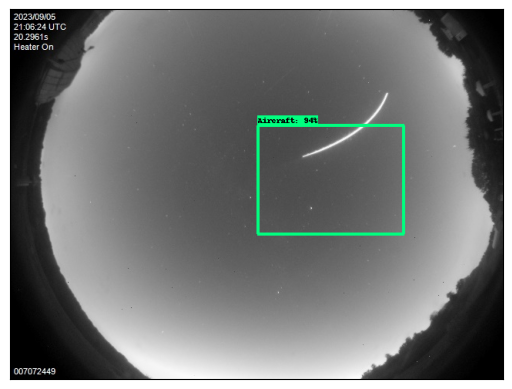

In [ ]:
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

plt.xticks([])
plt.yticks([])

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.5 ,  #edit
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
IMAGE_PATH = '/content/Tensorflow/workspace/images/test/56fa5579-74af7370-AllSkyImage007072446.JPG'


In [ ]:
tf.config.run_functions_eagerly(True)

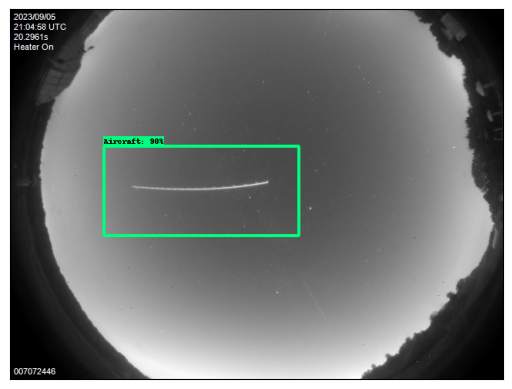

In [ ]:
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

plt.xticks([])
plt.yticks([])

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.5 ,  #edit
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()